# [CIFAR-10 Python](https://www.kaggle.com/datasets/pankrzysiu/cifar10-python) with Pre-trained model VGG16 and data Augmentation

Author: [1chooo](https://1chooo.com)

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras import models, layers
import keras as k
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator


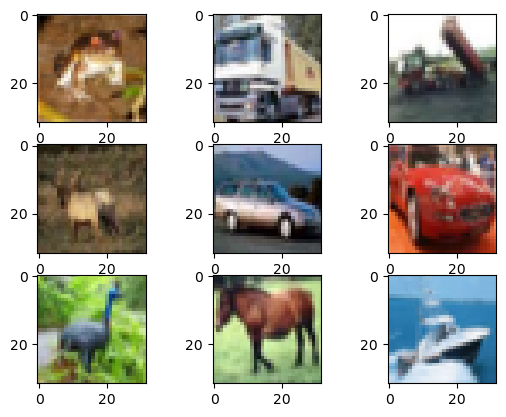

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [5]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

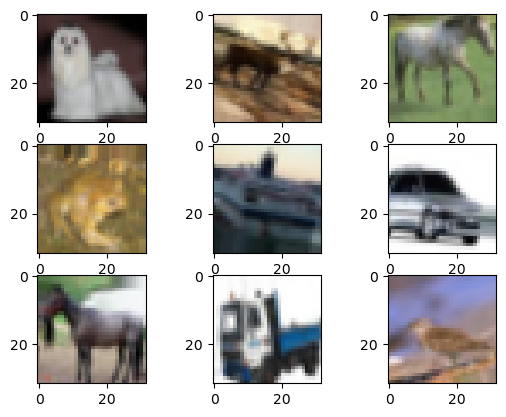

In [6]:
# see example augmentation images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [7]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [8]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std


In [13]:
# labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)

In [31]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [19]:
# build and compile the model  (roughly following the VGG paper)

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
adm=Adam(learning_rate=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [21]:
# training without augmentation
history=model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 15s 18ms/step - loss: 1.4786 - accuracy: 0.5147 - val_loss: 1.1629 - val_accuracy: 0.5909
Epoch 2/100
391/391 [==============================] - 6s 16ms/step - loss: 0.8819 - accuracy: 0.6906 - val_loss: 0.7936 - val_accuracy: 0.7218
Epoch 3/100
391/391 [==============================] - 6s 15ms/step - loss: 0.6865 - accuracy: 0.7593 - val_loss: 0.8046 - val_accuracy: 0.7174
Epoch 4/100
391/391 [==============================] - 6s 15ms/step - loss: 0.5748 - accuracy: 0.7976 - val_loss: 0.6814 - val_accuracy: 0.7686
Epoch 5/100
391/391 [==============================] - 6s 16ms/step - loss: 0.4758 - accuracy: 0.8330 - val_loss: 0.6408 - val_accuracy: 0.7863
Epoch 6/100
391/391 [==============================] - 6s 15ms/step - loss: 0.4136 - accuracy: 0.8552 - val_loss: 0.6811 - val_accuracy: 0.7801
Epoch 7/100
391/391 [==============================] - 6s 16ms/step - loss: 0.3338 - accuracy: 0.8830 - val_loss: 0.7320 - val_accuracy

In [24]:
#training accuracy without dropout
train_acc=model.evaluate(x_train,y_train,batch_size=128)
train_acc
# print('Test accuracy:', test_acc)

391/391 [==============================] - 3s 6ms/step - loss: 0.0047 - accuracy: 0.9985


[0.004653708077967167, 0.9984599947929382]

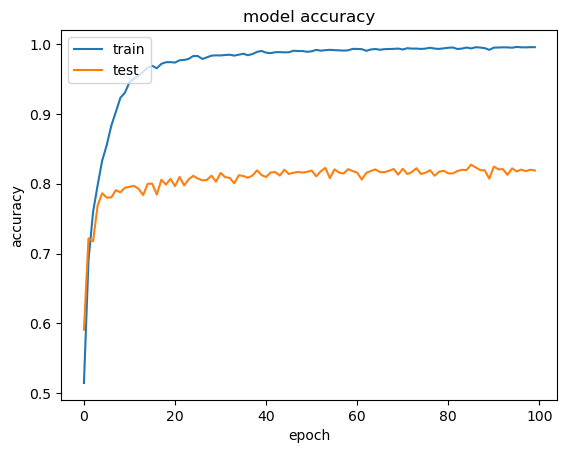

In [32]:
plothist(history)

In [34]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - loss: 1.3844 - accuracy: 0.8188 - 1s/epoch - 4ms/step


In [35]:
print('Test accuracy:', test_acc)

Test accuracy: 0.8187999725341797


## Reference

[Image-Augmentation-in-Keras-CIFAR-10-](https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb)
